In [6]:
import numpy as np
import pandas as pd

In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text

     |████████████████████████████████| 4.3MB 9.1MB/s 


In [4]:
!pip install tf-models-official

     |████████████████████████████████| 1.6MB 11.2MB/s 
     |████████████████████████████████| 102kB 14.3MB/s 
     |████████████████████████████████| 358kB 43.2MB/s 
     |████████████████████████████████| 686kB 59.4MB/s 
     |████████████████████████████████| 38.2MB 135kB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 174kB 65.0MB/s 
     |████████████████████████████████| 1.2MB 46.8MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 645kB 47.7MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-cp37-none-any.whl size=22258 sha256=047032d076be43346c3aa4d4055e8db93be6e4c895820ae122e2a945718645ff
  Stored in directory: /root/.cache/pip/wheels/2e/15/f5/aa2a056d223903b52cf4870134e3a01df0c723816835dd08db
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16184 sha256=fddaa3f77183bf96959e7860e228c2d60a24929c8af9cb25e7518e5cc9ca68a3
  Stored in directory: /r

In [5]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [41]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84131840/84125825 [==============================] - 5s 0us/step


In [42]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [43]:
bert_preprocess_model = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1')

In [44]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [45]:
bert_model = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3')

In [46]:
bert_results = bert_model(text_preprocessed)

#print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.9216988  -0.3935345  -0.5393172   0.6825623   0.43848485 -0.14021146
  0.87747115  0.26043332 -0.63112956 -0.9999658  -0.26320013  0.85105306]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.19451562  0.25141683  0.19075018 ... -0.24845089  0.38568544
   0.13291001]
 [-0.59478635 -0.39420357  0.2524575  ... -0.7694675   1.1564165
   0.32475677]
 [ 0.0064152  -0.1576646   0.5461019  ... -0.17451061  0.602896
   0.4267227 ]
 ...
 [ 0.21948323 -0.20927104  0.538683   ...  0.24693535  0.18250972
  -0.44427106]
 [ 0.01080239 -0.44553176  0.35990977 ...  0.3172279   0.23562792
  -0.63070583]
 [ 0.2932112  -0.10581939  0.6114753  ...  0.20745854  0.14494644
  -0.35353398]]


In [47]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1', name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3', trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [48]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.57773864]], shape=(1, 1), dtype=float32)


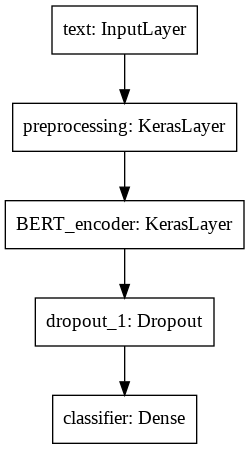

In [49]:
tf.keras.utils.plot_model(classifier_model)

In [50]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [51]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [52]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [54]:
#print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Epoch 1/5
625/625 [==============================] - 384s 590ms/step - loss: 0.3997 - binary_accuracy: 0.7972 - val_loss: 0.3233 - val_binary_accuracy: 0.8602
Epoch 2/5
625/625 [==============================] - 366s 586ms/step - loss: 0.2226 - binary_accuracy: 0.9087 - val_loss: 0.3490 - val_binary_accuracy: 0.8810
Epoch 3/5
625/625 [==============================] - 366s 586ms/step - loss: 0.1204 - binary_accuracy: 0.9598 - val_loss: 0.4597 - val_binary_accuracy: 0.8820
Epoch 4/5
625/625 [==============================] - 366s 586ms/step - loss: 0.0612 - binary_accuracy: 0.9825 - val_loss: 0.5786 - val_binary_accuracy: 0.8814
Epoch 5/5
625/625 [==============================] - 366s 586ms/step - loss: 0.0290 - binary_accuracy: 0.9921 - val_loss: 0.6190 - val_binary_accuracy: 0.8866


In [55]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 160s 204ms/step - loss: 0.5990 - binary_accuracy: 0.8872
Loss: 0.5989660024642944
Accuracy: 0.8872399926185608


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


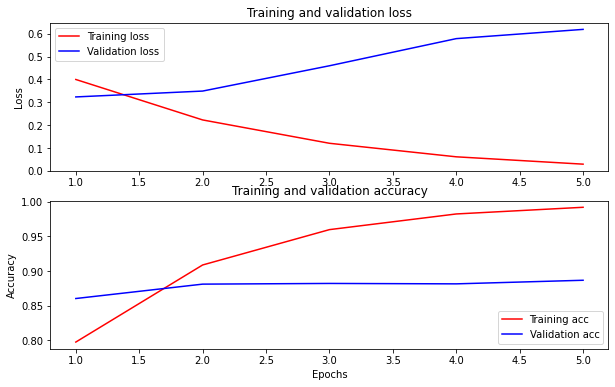

In [56]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [57]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [58]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [59]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.996255
input: The movie was great!           : score: 0.991437
input: The movie was meh.             : score: 0.165737
input: The movie was okish.           : score: 0.052104
input: The movie was terrible...      : score: 0.002710

Results from the model in memory:
input: this is such an amazing movie! : score: 0.996255
input: The movie was great!           : score: 0.991437
input: The movie was meh.             : score: 0.165737
input: The movie was okish.           : score: 0.052104
input: The movie was terrible...      : score: 0.002710



In [60]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.996255
input: The movie was great!           : score: 0.991437
input: The movie was meh.             : score: 0.165737
input: The movie was okish.           : score: 0.052104
input: The movie was terrible...      : score: 0.002710

